In [1]:
import wandb
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
wandb.login()
api = wandb.Api()

wandb: Currently logged in as: emiel-witting (fsoconut) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
runs = []
runs.append(api.run("fsoconut/generative-modelling/xtp8u6e7")) # Baseline
runs.append(api.run("fsoconut/generative-modelling/i8j6imf4")) # Linear
runs.append(api.run("fsoconut/generative-modelling/shs62pq8")) # Adam

for run in runs:
    print(run.name)
    print(run.summary)

Baseline
{'Training/acc': {'max': 0.921875}, 'Training/energy_fake': 1003.55029296875, 'Training/energy_real': 92.3673095703125, 'Training/fid': {'min': 237.8887939453125}, 'Training/grad_ratios': -0.9964844584465028, 'Training/grad_ratios_below_minus_one': 0.328125, 'Training/grad_ratios_minimum': -1.0226757526397705, 'Training/l1': 1.6576701402664185, 'Training/loss': -907.4700317382812, 'Training/loss_clf': 3.7129220962524414, 'Training/loss_gen': -911.1829833984376, '_runtime': 217.2643722, '_step': 455, '_timestamp': 1749404487.8373642, '_wandb': {'runtime': 218}, 'batch': 455, 'epoch': 1}
Linear Decay
{'Testing/acc': 0.8504820478723404, 'Training/acc': {'max': 1}, 'Training/energy_fake': 33.946048736572266, 'Training/energy_real': -15.878660202026367, 'Training/fid': {'min': 84.70146179199219}, 'Training/grad_ratios': -0.1416628062725067, 'Training/grad_ratios_below_minus_one': 0, 'Training/grad_ratios_minimum': -0.7573004961013794, 'Training/l1': 0.8935527205467224, 'Training/lo

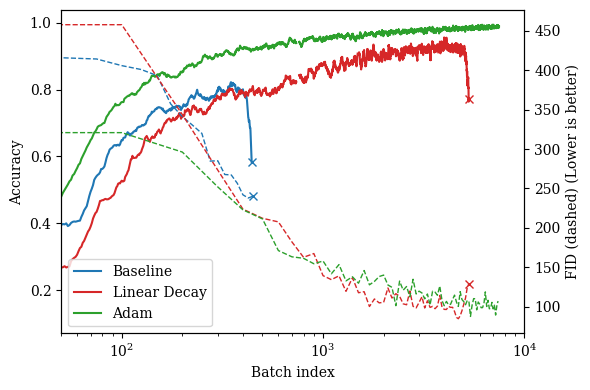

In [4]:
plt.rcParams['font.family'] = 'serif'

fig, ax1 = plt.subplots(figsize=(6,4))
ax2 = ax1.twinx()

color_map = {
    'Baseline': 'tab:blue',
    'Linear Decay': 'tab:red',
    'Adam': 'tab:green'
}

for run in runs:
    history = run.history(samples=10000)
    run_ended = len(history) < 7000
    acc = history['Training/acc'].values
    acc_x = history['batch'].values
    acc_width = 25
    acc_smooth = np.convolve(acc, np.ones(acc_width)/acc_width, mode='valid')
    acc_x = acc_x[acc_width//2 - 1:-acc_width//2]
    ax1.plot(acc_x, acc_smooth, label=run.name, color=color_map[run.name])

    if run_ended:
        last_x = acc_x[-1]
        last_y = acc_smooth[-1]
        ax1.plot(last_x, last_y, 'x', color=color_map[run.name], markersize=6, markeredgewidth=1)

    fid = history['Training/fid'].values
    fid_x = history['batch'].values[~np.isnan(fid)]
    fid = fid[~np.isnan(fid)]
    ax2.plot(fid_x, fid, label=run.name, color=color_map[run.name], linestyle='--', linewidth=1)

    if run_ended:
        last_x = fid_x[-1]
        last_y = fid[-1]
        ax2.plot(last_x, last_y, 'x', color=color_map[run.name], markersize=6, markeredgewidth=1)


ax1.legend(loc='lower left')
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('FID (dashed) (Lower is better)')


ax1.set_xlabel('Batch index')
ax1.set_xscale('log')
ax1.set_xlim(50,10000)
plt.tight_layout()

plt.savefig('modification_perf.png', dpi=300)
plt.show()

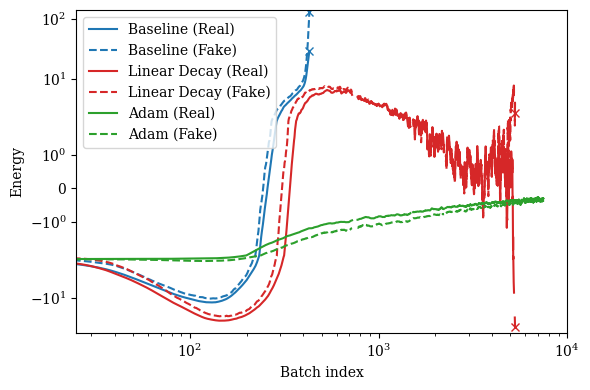

In [13]:
plt.figure(figsize=(6,4))
ax = plt.gca()

for run in runs:
    history = run.history(samples=10000)
    run_ended = len(history) < 7000
    
    energy_real = history['Training/energy_real'].values
    energy_real_x = history['batch'].values
    width = 50
    energy_real_smooth = np.convolve(energy_real, np.ones(width)/width, mode='valid')
    energy_real_x = energy_real_x[width//2 - 1:-width//2]
    ax.plot(energy_real_x, energy_real_smooth, label=f'{run.name} (Real)', color=color_map[run.name])

    if run_ended:
        last_x = energy_real_x[-1]
        last_y = energy_real_smooth[-1]
        ax.plot(last_x, last_y, 'x', color=color_map[run.name], markersize=6, markeredgewidth=1)

    energy_fake = history['Training/energy_fake'].values
    energy_fake_x = history['batch'].values
    energy_fake_smooth = np.convolve(energy_fake, np.ones(width)/width, mode='valid')
    energy_fake_x = energy_fake_x[width//2 - 1:-width//2]
    ax.plot(energy_fake_x, energy_fake_smooth, label=f'{run.name} (Fake)', color=color_map[run.name], linestyle='--')

    if run_ended:
        last_x = energy_fake_x[-1]
        last_y = energy_fake_smooth[-1]
        ax.plot(last_x, last_y, 'x', color=color_map[run.name], markersize=6, markeredgewidth=1)

ax.legend(loc='best')
ax.set_ylabel('Energy')
ax.set_xlabel('Batch index')
ax.set_xscale('log')
ax.set_xlim(25,10000)
ax.set_yscale('symlog')
plt.tight_layout()

plt.savefig('modification_energy.png', dpi=300)
plt.show()
